In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import load_model
import os

from keras.optimizers import Adam

from fully_conv_model_for_lidar import fcn_model
from util_func import *
from train import *

from keras.utils.generic_utils import get_custom_objects
#loss = SSD_Loss(neg_pos_ratio=neg_pos_ratio, alpha=alpha)
get_custom_objects().update({"my_loss": my_loss})

#import keras.losses
#keras.losses.custom_loss = my_loss

Using TensorFlow backend.


In [2]:
model = load_model('saved_model/model.h5')

[<tf.Tensor 'gradients/split_1_grad/concat:0' shape=(?, 64, 256, 10) dtype=float32>, None, None]


In [3]:
lidar = np.load('./extract_kiti/0005/lidar/lidar_0.npy')
gt_box = np.load('./extract_kiti/0005/gt_boxes3d/gt_boxes3d_0.npy')
view, box = cylindrical_projection_with_labels(lidar, gt_box)
print(view.shape, box.shape)

((64, 256, 2), (64, 256, 10))


In [4]:
view = view.reshape(1,64,256,2)
pred = model.predict(view)
print(pred.shape)

(1, 64, 256, 10)


In [5]:
label_view = cylindrical_projection_for_test(lidar)
print(label_view.shape)

(64, 256, 5)


In [6]:
pred_view = pred[0]
boxes = np.zeros((64,256,8,3))

In [7]:
for i in range(64):
    for j in range(256):
        boxes[i,j,0] = label_view[i,j,:3] - rotation(label_view[i,j,3],pred_view[i,j,1:4])
        boxes[i,j,1] = label_view[i,j,:3] - rotation(label_view[i,j,3],pred_view[i,j,4:7])
        boxes[i,j,6] = label_view[i,j,:3] - rotation(label_view[i,j,3],pred_view[i,j,7:10])
        boxes[i,j,2] = [boxes[i,j,6,0], boxes[i,j,6,1], boxes[i,j,0,2]]
        boxes[i,j,3] = boxes[i,j,0] + boxes[i,j,2] - boxes[i,j,1]
        boxes[i,j,4] = boxes[i,j,0] + boxes[i,j,6] - boxes[i,j,2]
        boxes[i,j,5] = boxes[i,j,1] + boxes[i,j,4] - boxes[i,j,0]
        boxes[i,j,7] = boxes[i,j,4] + boxes[i,j,6] - boxes[i,j,5]


In [8]:
pred_boxes = boxes[pred_view[:,:,0]>0.5].reshape(-1,8,3)
print(pred_boxes.shape)

(1071, 8, 3)


In [9]:
viz_mayavi_with_labels(lidar, pred_boxes[[1,100,200,500,1000]])

In [ ]:
viz_mayavi_with_labels(lidar, pred_boxes)

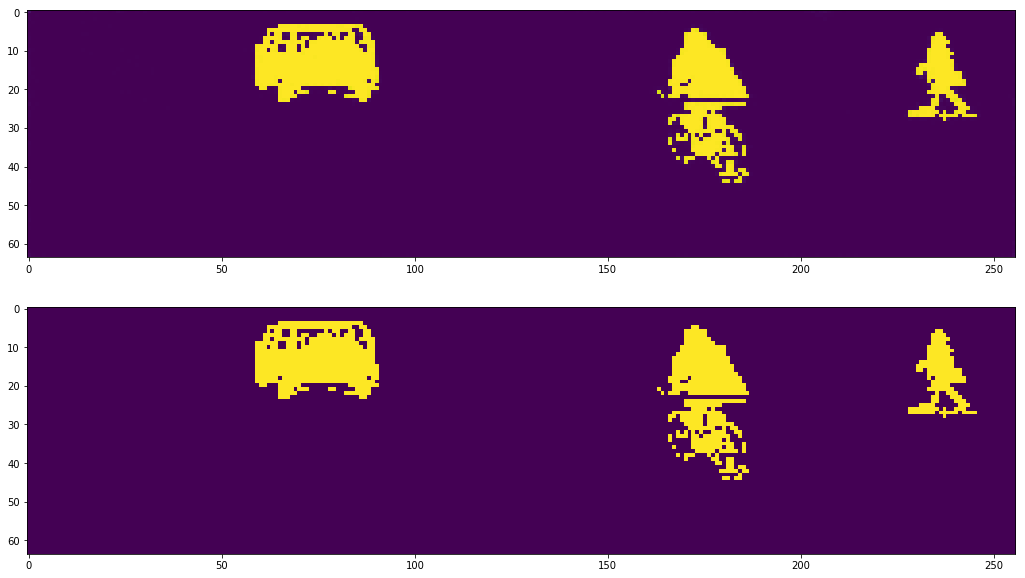

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(2,1, figsize=(24,10))
ax[0].imshow(pred_view[:,:,0])
    #ax[1].imshow(pred_view[:,:,1])
ax[1].imshow(box[:,:,0])
#ax[3].imshow(view[0,:,:,1])

In [11]:
reshape_boxes = boxes.reshape(-1,24)

### Continue training

In [14]:
data_dir = './extract_kiti/'

list_of_lidar, list_of_gtbox = list_of_data(data_dir)

# test on just one sample
list_of_lidar = [list_of_lidar[108]]
list_of_gtbox = [list_of_gtbox[108]]

In [15]:
model.fit_generator(generator=train_batch_generator(list_of_lidar, list_of_gtbox, batch_size = 1, data_augmentation = False),
                        steps_per_epoch=1,
                        epochs=50)

Epoch 1/50
1/1 [==============================] - 3s - loss: 0.7275
Epoch 2/50
1/1 [==============================] - 2s - loss: 0.7238
Epoch 3/50
1/1 [==============================] - 2s - loss: 0.7201
Epoch 4/50
1/1 [==============================] - 2s - loss: 0.7164
Epoch 5/50
1/1 [==============================] - 2s - loss: 0.7128
Epoch 6/50
1/1 [==============================] - 3s - loss: 0.7091
Epoch 7/50
1/1 [==============================] - 2s - loss: 0.7055
Epoch 8/50
1/1 [==============================] - 2s - loss: 0.7019
Epoch 9/50
1/1 [==============================] - 2s - loss: 0.6984
Epoch 10/50
1/1 [==============================] - 2s - loss: 0.6949
Epoch 11/50
1/1 [==============================] - 2s - loss: 0.6913
Epoch 12/50
1/1 [==============================] - 2s - loss: 0.6878
Epoch 13/50
1/1 [==============================] - 3s - loss: 0.6844
Epoch 14/50
1/1 [==============================] - 3s - loss: 0.6809
Epoch 15/50
1/1 [==========================

KeyboardInterrupt: 

In [ ]:
model.save("saved_model/model.h5")